In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report,  precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  Input, Dropout, Conv2D, MaxPooling2D, Flatten

from pytorch_tabnet.tab_model import TabNetClassifier
import torch



In [2]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

In [3]:
df = pd.read_excel('df.xlsx')
print("Dimensions of the dataset:", df.shape)

nas_per_column = df.isna().sum()
columns_with_nas = nas_per_column[nas_per_column > 0]
print("\nColumns with missing values and their counts:")
print(columns_with_nas)

# to predict: without_formal_contract, envelope_wage, dep_self_empl, has_OR_would_have_undeclared_salary
#print("\nNames of columns:", df.columns.tolist())
columns_to_drop = ['without_formal_contract', 'envelope_wage', 'dep_self_empl', 'has_OR_would_have_undeclared_salary']

# Separate features and target
X = df.drop(columns=columns_to_drop, axis=1)
y = df['dep_self_empl']

# Class imbalance
print('\nClass imbalance for dep_self_empl :\n', df['dep_self_empl'].value_counts())

Dimensions of the dataset: (27565, 130)

Columns with missing values and their counts:
Series([], dtype: int64)

Class imbalance for dep_self_empl :
 0    27504
1       61
Name: dep_self_empl, dtype: int64


# Class Balance: Undersample

In [4]:
# Define the undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# Resample the data
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of the resampled dataset:", X_resampled.shape)
print("Dimensions of train:", X_train.shape)
print("Dimensions of test:", X_test.shape)
print('\nClass balance for without_formal_contract :\n', y_resampled.value_counts())

Dimensions of the resampled dataset: (122, 126)
Dimensions of train: (97, 126)
Dimensions of test: (25, 126)

Class balance for without_formal_contract :
 0    61
1    61
Name: dep_self_empl, dtype: int64


# 1. Random Forest

In [6]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Grid search
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Grid Search with a fixed random state
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)


# Fit the Grid Search to the data
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Elapsed time:", end_time - start_time, "seconds")
print(f"Best Parameters: {best_params}")

# Predict and evaluate on the training set
y_train_pred = best_rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Set Accuracy: {training_accuracy:.4f}")

# Predict and evaluate on the test set
y_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Elapsed time: 33.232830286026 seconds
Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training Set Accuracy: 1.0000
Test Set Accuracy: 0.8000


Training Set Accuracy: 1.0000
Test Set Accuracy: 0.8000
Confusion Matrix:
[[11  4]
 [ 1  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.69      0.90      0.78        10

    accuracy                           0.80        25
   macro avg       0.80      0.82      0.80        25
weighted avg       0.83      0.80      0.80        25



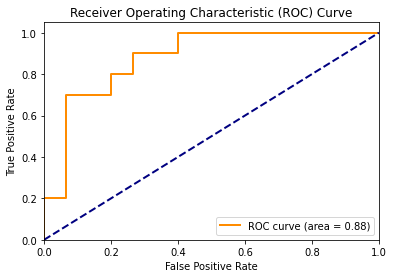

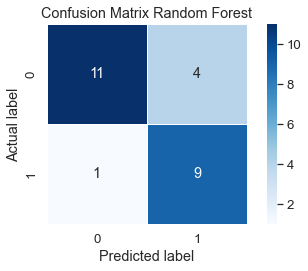

In [5]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Set the best parameters
best_params = {'max_depth':10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Train the model
best_rf.fit(X_train, y_train)

# Predict and evaluate on the training set
y_train_pred = best_rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Set Accuracy: {training_accuracy:.4f}")

# Predict and evaluate on the test set
y_pred_RF = best_rf.predict(X_test) 
test_accuracy = accuracy_score(y_test, y_pred_RF)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_RF)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RF))

# ROC Curve using predicted probabilities
y_pred_proba_RF = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_RF)
roc_auc_RF = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix Random Forest')

# Adjust layout
plt.tight_layout()
plt.show()

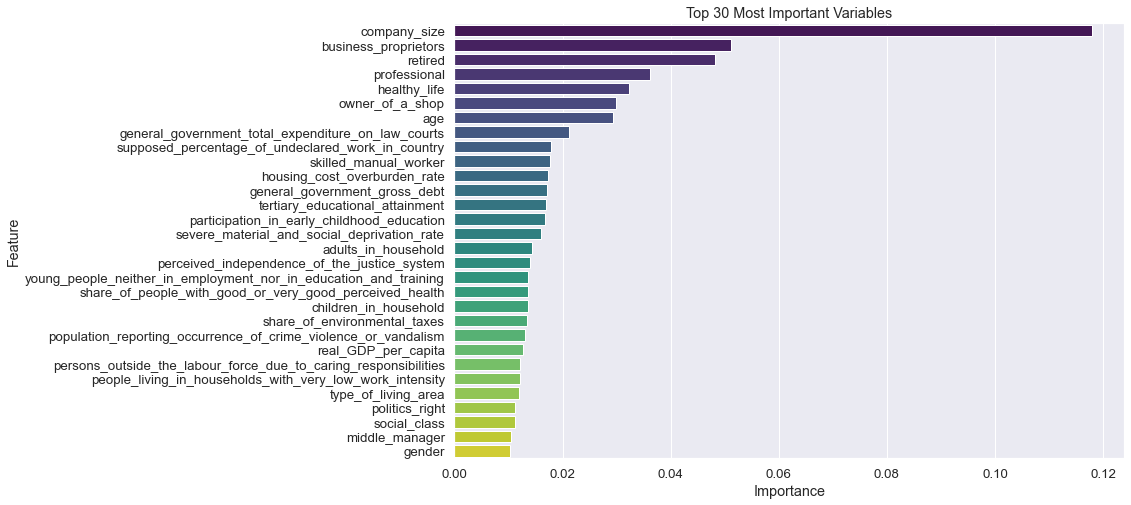

In [6]:

# Importance of variables
importances = best_rf.feature_importances_

# Get indices of top 30 features in descending order
top_indices = importances.argsort()[-30:][::-1]

# Get feature names
feature_names = X.columns

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': [feature_names[i] for i in top_indices], 'Importance': importances[top_indices]})

# Plot the importance of top 30 variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()

# 2. MLP Neural Network

In [33]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
def add_layers(layers_dict):
    
    # Initialization
    model = Sequential()

    # Add layers
    model.add(Input(shape=(126,))) # 126 = number of variables
    model.add(Dense(layers_dict['inic']['uni'], activation=layers_dict['inic']['activ']))
    for i in list(layers_dict.keys())[1:-2]:
        model.add(Dense(layers_dict[i]['uni'], activation=layers_dict[i]['activ']))      # hidden layer i
        if 'dropout' in layers_dict[i]:
            model.add(Dropout(rate=layers_dict[i]['dropout']))
    model.add(Dense(layers_dict['end']['uni'], activation=layers_dict['end']['activ']))  # exit layer

    # Compile model
    model.compile(loss=layers_dict['compile']['loss'],
                  optimizer=layers_dict['compile']['optimizer'],
                  metrics=layers_dict['compile']['metrics'])
    return model

#-----------------------------------------------------------------------------------------------

def train_model(model, X_train, X_test, y_train, y_test, **kwargs):
    epochs = kwargs.get('epochs', 5)
    batch_size = kwargs.get('batch_size', 1)
    verbose = kwargs.get('verbose', 1)
    
    # SET SEEDS
    np.random.seed(140)
    tf.random.set_seed(134)
    tf.keras.utils.set_random_seed(44)
    torch.manual_seed(140)
    
    # Training
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    train_accuracy = history.history['accuracy'][-1]
    
    # Predictions and evaluation
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5)
    score = model.evaluate(X_test, y_test, verbose=1)
    test_accuracy = score[1]

    # Predictions and evaluation
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    # Put results in dataframe
    results = pd.Series({'Layers': (len(model.layers) - 2)/2,  # Excluding input and output layers, and dropouts
                         'Epochs': epochs,
                         'Batch_Size': batch_size,
                         'Train_accuracy': train_accuracy,
                         'Test_Accuracy':   test_accuracy,
                         'Precision': precision,
                         'Recall': recall,
                         'F1_Score': f1,
                         'Kappa_Score': kappa})

    return model, results,  y_pred, y_pred_prob, train_accuracy,  test_accuracy

#------------------------------------------------------------------------------------------------

def get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1):
    
    # SET SEEDS
    np.random.seed(140)
    tf.random.set_seed(134)
    tf.keras.utils.set_random_seed(44)
    torch.manual_seed(140)

    # compile model
    model = add_layers(layers_dict)

    # train + predict model
    model, results_df, y_pred, y_pred_prob, train_accuracy,  test_accuracy = train_model(model, X_train, X_test, y_train, y_test, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Nr of hidden layers and f_activ
    uni_ocultas = []
    f_activ = []
    for i in list(layers_dict.keys())[1:-2]:
        uni_ocultas.append(layers_dict[i]['uni'])
        f_activ.append(layers_dict[i]['activ'])
        
    results_df['Hidden_Layers'] = str(uni_ocultas)
    results_df['F_activ'] = str(f_activ)
    results_df['Loss'] = layers_dict['compile']['loss']
    results_df['Optimizer'] = layers_dict['compile']['optimizer']
    results_df = results_df[['Layers', 'Hidden_Layers', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Train_accuracy', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score']]
    return model, results_df, y_pred, y_pred_prob, train_accuracy,  test_accuracy

In [35]:
df_all_results_relu = pd.DataFrame(columns=['Layers', 'Hidden_Layers', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Train_accuracy', 'Test_Accuracy',
                                        'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])

In [32]:
# SEARCH FOR BEST MODEL
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

file = 'dep_self_empl_MLP_relu.csv'

# List of common optimizers
optimizers = [
    'SGD',     # Stochastic Gradient Descent
    'Adam',    # Adam
    'Adamax'  # Adamax
]

start_time = time.time()

# Loop through the list of optimizers and compile the model with each one
for optimizer in optimizers:
    
    #RELU, 1 strat
    n = 0
    for l1 in [252, 126, 64, 32, 8,2]:
                n = n + 1
                layers_dict = {
                    'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                    'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                    'end' : {'uni': 1, 'activ': 'sigmoid'},
                    'compile' : {'loss': 'binary_crossentropy', 'optimizer' : optimizer, 'metrics' : ['accuracy']}
                }
                print(optimizer +  ": 1layer, " +  str(n) + "/6")
                model, results_df, y_pred, y_pred_prob, train_accuracy,  test_accuracy = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
                print()
    df_all_results_relu.to_csv(file, index=False)



    # RELU, 2 straturi
    n = 0
    for l1 in [252, 126, 64]:
        for l2 in [126, 64, 32, 8, 4, 2]:
            n = n + 1
            layers_dict = {
                'inic' : {'uni': 126, 'activ': 'relu', 'input_s': (126,)}, 
                'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                'end' : {'uni': 1, 'activ': 'sigmoid'},
                'compile' : {'loss': 'binary_crossentropy', 'optimizer' : optimizer, 'metrics' : ['accuracy']}
            }
            print(optimizer +  ": 2layers, " +  str(n) + "/18")
            model, results_df, y_pred, y_pred_prob, train_accuracy,  test_accuracy = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
            results_df = pd.DataFrame(results_df).T
            df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
            print()
    df_all_results_relu.to_csv(file, index=False)


    #RELU, 3 straturi
    n=0
    for l1 in [252]:
        for l2 in [126, 64, 32]:
            for l3 in [64, 32, 8, 2]:
                n = n + 1
                layers_dict = {
                    'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                    'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                    'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                    'l3' : {'uni': l3, 'activ': 'relu', 'dropout': 0.2},
                    'end' : {'uni': 1, 'activ': 'sigmoid'},
                    'compile' : {'loss': 'binary_crossentropy', 'optimizer' : optimizer, 'metrics' : ['accuracy']}
                }
                print(optimizer +  ": 3layers, " +  str(n) + "/12")
                model, results_df, y_pred, y_pred_prob, train_accuracy,  test_accuracy = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
                print()
    df_all_results_relu.to_csv(file, index=False)



    #RELU, 4 straturi
    n = 0
    for l1 in [252]:
        for l2 in [126, 64, 32]:
            for l3 in [64, 32, 8]:
                for l4 in [ 32, 8, 4, 2]:
                    n = n + 1
                    layers_dict = {
                        'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                        'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                        'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                        'l3' : {'uni': l3, 'activ': 'relu', 'dropout': 0.2},
                        'l4' : {'uni': l4, 'activ': 'relu', 'dropout': 0.2},
                        'end' : {'uni': 1, 'activ': 'sigmoid'},
                        'compile' : {'loss': 'binary_crossentropy', 'optimizer' : optimizer, 'metrics' : ['accuracy']}
                    }
                    print(optimizer +  ": 4layers, " +  str(n) + "/36")
                    model, results_df, y_pred, y_pred_prob, train_accuracy,  test_accuracy = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                    results_df = pd.DataFrame(results_df).T
                    df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
                    print()
    df_all_results_relu.to_csv(file, index=False)


    #RELU, 5 straturi
    n = 0
    for l1 in [252]:
        for l2 in [126, 64, 32]:
            for l3 in [64, 32, 8]:
                for l4 in [ 32, 8, 4]:
                    for l5 in [ 8, 4, 2]:
                        n = n + 1
                        layers_dict = {
                            'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                            'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                            'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                            'l3' : {'uni': l3, 'activ': 'relu', 'dropout': 0.2},
                            'l4' : {'uni': l4, 'activ': 'relu', 'dropout': 0.2},
                            'l5' : {'uni': l5, 'activ': 'relu', 'dropout': 0.2},
                            'end' : {'uni': 1, 'activ': 'sigmoid'},
                            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : optimizer, 'metrics' : ['accuracy']}
                        }
                        print(optimizer +  ": 5layers, " +  str(n) + "/81")
                        model, results_df, y_pred, y_pred_prob, train_accuracy,  test_accuracy = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                        results_df = pd.DataFrame(results_df).T
                        df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
                        print()
    df_all_results_relu.to_csv(file, index=False)
    


end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")

SGD: 1layer, 1/6
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.4701 - loss: 0.7148   
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.9116 - loss: 0.3431
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 1.0000 - loss: 0.1724
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 1.0000 - loss: 0.1031
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 1.0000 - loss: 0.0633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8400 - loss: 0.5028

SGD: 1layer, 2/6
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.4961 - loss: 0.7653
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.9123 - loss: 0.3608
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.9888 - loss: 0.1873
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 1.0000 - loss: 0.0959
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 1.0000 - loss: 0.0570
1

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.6332 - loss: 0.6379 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.6987 - loss: 0.5505
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.8240 - loss: 0.4786
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.8237 - loss: 0.4228
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6000 - loss: 0.8291

SGD: 2layers, 6/18
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.6486 - loss: 0.6864
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.6834 - loss: 0.5636
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.7714 - loss: 0.3903 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.8362 - loss: 0.2236
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.9269 - loss: 0.1549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7200 - loss: 0.6493

S

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.9126 - loss: 0.3049
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.9267 - loss: 0.2005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7600 - loss: 0.4657

SGD: 2layers, 16/18
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.5440 - loss: 0.7618
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.8323 - loss: 0.4811
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.8341 - loss: 0.3649 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.9355 - loss: 0.2478
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.9627 - loss: 0.1396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7200 - loss: 0.5020

SGD: 2layers, 17/18
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.5599 - loss: 0.7103
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7600 - loss: 0.6065

SGD: 3layers, 8/12
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.4468 - loss: 0.8156   
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.7044 - loss: 0.6345
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.7798 - loss: 0.5738
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.8002 - loss: 0.5253
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.8382 - loss: 0.4916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6800 - loss: 0.5117

SGD: 3layers, 9/12
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.4071 - loss: 0.7133    
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.5724 - loss: 0.6529
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.7893 - loss: 0.5741
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5083 - loss: 0.7163     
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.6426 - loss: 0.6573
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.7537 - loss: 0.5319 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.7523 - loss: 0.4661
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.9428 - loss: 0.2255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8000 - loss: 0.5375

SGD: 4layers, 7/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6367 - loss: 0.6953
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.6414 - loss: 0.6471 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.7393 - loss: 0.5619 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.8012 - loss: 0.4929
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.9039 - loss: 0.1996
1/1 ━━━━━━━━━━━━━━━━━━━━ 

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.6778 - loss: 0.6108 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.7852 - loss: 0.5370
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.8626 - loss: 0.3653
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.8760 - loss: 0.2418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7200 - loss: 0.5020

SGD: 4layers, 17/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.5173 - loss: 0.7094   
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.6977 - loss: 0.6532
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.7001 - loss: 0.6012 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.8119 - loss: 0.3826
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.8951 - loss: 0.2296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8000 - loss: 0.55

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.6668 - loss: 0.6623
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.6439 - loss: 0.6641 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.8198 - loss: 0.5606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7200 - loss: 0.5447

SGD: 4layers, 27/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - accuracy: 0.5479 - loss: 0.7017
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.4891 - loss: 0.6886 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.4818 - loss: 0.6869 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.6653 - loss: 0.6351
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.6638 - loss: 0.6141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5600 - loss: 0.6991

SGD: 4layers, 28/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.5469 - loss: 0.6849
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.6576 - loss: 0.6486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6000 - loss: 0.6010

SGD: 5layers, 1/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5247 - loss: 0.7187 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.3859 - loss: 0.7088 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.6076 - loss: 0.6731
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6743 - loss: 0.6324
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7746 - loss: 0.5424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7600 - loss: 0.4535

SGD: 5layers, 2/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5107 - loss: 0.6937
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.6032 - 

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.5063 - loss: 0.6958   
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.5879 - loss: 0.6857 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7238 - loss: 0.6661
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.6836 - loss: 0.6475
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.7543 - loss: 0.6206
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7200 - loss: 0.6304

SGD: 5layers, 8/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5591 - loss: 0.7000   
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.6195 - loss: 0.6930
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.5567 - loss: 0.7072
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.5594 - loss: 0.6716
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.5885 - loss: 0.6853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.5775 - loss: 0.6977 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.5717 - loss: 0.7028
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.5762 - loss: 0.6876
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.5762 - loss: 0.6900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4000 - loss: 0.6973

SGD: 5layers, 18/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - accuracy: 0.4834 - loss: 0.6920    
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.5762 - loss: 0.6931
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5762 - loss: 0.6934
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.5762 - loss: 0.6886
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.5762 - loss: 0.6862
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4000 - loss: 0.69

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4543 - loss: 0.6619   
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.4044 - loss: 0.6794 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.7520 - loss: 0.5561
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6400 - loss: 0.7054

SGD: 5layers, 28/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.5805 - loss: 0.6919
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.5352 - loss: 0.6986
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.6305 - loss: 0.6621 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.5211 - loss: 0.6799 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.7831 - loss: 0.6012
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7200 - loss: 0.5331

SGD: 5layers, 29/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy:

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.5731 - loss: 0.6520 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.7920 - loss: 0.5172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7600 - loss: 0.5098

SGD: 5layers, 38/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5158 - loss: 0.7126     
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.4409 - loss: 0.6856
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.4396 - loss: 0.7015 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5358 - loss: 0.6975
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.6069 - loss: 0.6816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5600 - loss: 0.6645

SGD: 5layers, 39/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.5544 - loss: 0.6805
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.4892 - loss: 0.7078    
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.5594 - loss: 0.6932 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.4186 - loss: 0.7303 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.6476 - loss: 0.6717
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.5171 - loss: 0.6829
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5200 - loss: 0.6865

SGD: 5layers, 44/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accuracy: 0.5357 - loss: 0.6766    
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.5064 - loss: 0.6641 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.5330 - loss: 0.6842 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.6411 - loss: 0.6199
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.6055 - loss: 0.6180
1/1 ━━━━━━━━━━━━

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5732 - loss: 0.6899 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.4266 - loss: 0.7006 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.5079 - loss: 0.6898
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.5144 - loss: 0.6856
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6800 - loss: 0.6804

SGD: 5layers, 54/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4662 - loss: 0.7108      
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.5762 - loss: 0.6921
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.5762 - loss: 0.6855
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.5762 - loss: 0.6950
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.5762 - loss: 0.6934
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4000 - loss: 0.6

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.5762 - loss: 0.6843
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.5523 - loss: 0.6722
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.5461 - loss: 0.6165 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6000 - loss: 0.6897

SGD: 5layers, 64/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4544 - loss: 0.7016      
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.4851 - loss: 0.6857
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.5682 - loss: 0.6904
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.4838 - loss: 0.6998 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6144 - loss: 0.6497 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6000 - loss: 0.6283

SGD: 5layers, 65/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accura

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.6023 - loss: 0.6922
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.5257 - loss: 0.6888 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4800 - loss: 0.6919

SGD: 5layers, 74/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.4108 - loss: 0.7027    
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.5661 - loss: 0.6784 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.6519 - loss: 0.6529
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.6428 - loss: 0.6041 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.6627 - loss: 0.5458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7600 - loss: 0.6084

SGD: 5layers, 75/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - accuracy: 0.5058 - loss: 0.6992    
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - ac

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 1.0000 - loss: 0.0108 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8400 - loss: 0.5360

Adam: 1layer, 3/6
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.5432 - loss: 0.7276
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.9412 - loss: 0.2669
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 1.0000 - loss: 0.1009
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 1.0000 - loss: 0.0459
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 1.0000 - loss: 0.0228
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8000 - loss: 0.5313

Adam: 1layer, 4/6
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3519 - loss: 0.8870      
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.8541 - loss: 0.3471
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8400 - loss: 0.5179

Adam: 2layers, 7/18
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5491 - loss: 0.6937      
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.8886 - loss: 0.3311
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.9998 - loss: 0.0614
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 1.0000 - loss: 0.0142
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 1.0000 - loss: 0.0079
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8400 - loss: 0.8016

Adam: 2layers, 8/18
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - accuracy: 0.5735 - loss: 0.7143
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.9501 - loss: 0.2754
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.9998 - loss: 0.0830
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.9963 - loss: 0.0214
Epoch 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6384 - loss: 0.7110
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.8159 - loss: 0.4272
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.8240 - loss: 0.3141 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.9743 - loss: 0.1066
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.9714 - loss: 0.0997 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8000 - loss: 0.5713

Adam: 2layers, 18/18
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4534 - loss: 0.7647      
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5782 - loss: 0.6870
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.7101 - loss: 0.6454
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.7891 - loss: 0.4408
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.8681 - loss: 0.2581
1/1 ━━━━━━━━━━━━━━━━━━━━

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9383 - loss: 0.1511
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 1.0000 - loss: 0.0513 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 1.0000 - loss: 0.0084
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8800 - loss: 0.5283

Adam: 3layers, 10/12
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4907 - loss: 0.7139   
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.7226 - loss: 0.5502
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.9576 - loss: 0.1980
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 1.0000 - loss: 0.0427 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9872 - loss: 0.0200   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8800 - loss: 0.6366

Adam: 3layers, 11/12
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9384 - loss: 0.0883   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8400 - loss: 0.5306

Adam: 4layers, 8/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5488 - loss: 0.7028
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5348 - loss: 0.6265
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6928 - loss: 0.5638
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7635 - loss: 0.4937   
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9041 - loss: 0.2540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8000 - loss: 0.5884

Adam: 4layers, 9/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5662 - loss: 0.7070 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8298 - loss: 0.4696
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9373 - loss:

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4206 - loss: 0.7327 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6543 - loss: 0.6333
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8818 - loss: 0.3898
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9277 - loss: 0.2140
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9753 - loss: 0.1350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8000 - loss: 0.6854

Adam: 4layers, 19/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5641 - loss: 0.8178 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7013 - loss: 0.5495
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8158 - loss: 0.4481
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9229 - loss: 0.2035
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9766 - loss: 0.0455   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7635 - loss: 0.5145
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7481 - loss: 0.4167   
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8959 - loss: 0.1866   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7600 - loss: 0.6291

Adam: 4layers, 29/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4202 - loss: 0.7321 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 0.6485  
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8929 - loss: 0.4320
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9271 - loss: 0.1731
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0390 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8400 - loss: 0.7129

Adam: 4layers, 30/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5383 - 

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9574 - loss: 0.1744 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7600 - loss: 1.0164

Adam: 5layers, 3/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5103 - loss: 0.7174 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4324 - loss: 0.7205 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4906 - loss: 0.6728 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4953 - loss: 0.6891 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5620 - loss: 0.6343 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5600 - loss: 1.0660

Adam: 5layers, 4/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4813 - loss: 0.7099
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5670 - loss: 0.6895
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6612 - loss: 

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3960 - loss: 0.7273 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5916 - loss: 0.6897
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5903 - loss: 0.6930
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6817 - loss: 0.5712 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8969 - loss: 0.3375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8000 - loss: 0.5906

Adam: 5layers, 14/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6143 - loss: 0.7237
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7003 - loss: 0.6166 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7048 - loss: 0.5077 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7229 - loss: 0.3877 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8999 - loss: 0.1864
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5234 - loss: 0.6781 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5816 - loss: 0.6380
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8003 - loss: 0.4630
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6400 - loss: 0.6378

Adam: 5layers, 24/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5762 - loss: 0.7003
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3941 - loss: 0.7267
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5268 - loss: 0.6722 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6656 - loss: 0.5713
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8590 - loss: 0.5113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6800 - loss: 0.8352

Adam: 5layers, 25/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5385 - loss: 0.

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8291 - loss: 0.4167
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7200 - loss: 0.6855

Adam: 5layers, 34/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4940 - loss: 0.6990 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5227 - loss: 0.7126 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5614 - loss: 0.7124
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5779 - loss: 0.6741 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8523 - loss: 0.4696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8000 - loss: 0.5390

Adam: 5layers, 35/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6588 - loss: 0.6989
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5673 - loss: 0.7062 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5445 - loss: 

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5675 - loss: 0.7137 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6430 - loss: 0.6924 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5340 - loss: 0.7570 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6095 - loss: 0.6331
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8111 - loss: 0.5419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7600 - loss: 0.5996

Adam: 5layers, 45/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4975 - loss: 0.7683 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5762 - loss: 0.6811
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5762 - loss: 0.6826
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5762 - loss: 0.6926
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5762 - loss: 0.6853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5762 - loss: 0.6925
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5762 - loss: 0.6949
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5762 - loss: 0.6918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4000 - loss: 0.6954

Adam: 5layers, 55/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5802 - loss: 0.6914
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5582 - loss: 0.6708
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6404 - loss: 0.5930
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8280 - loss: 0.4063 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9085 - loss: 0.1638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8800 - loss: 0.3950

Adam: 5layers, 56/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5177 - loss: 0.7

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9693 - loss: 0.0857 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7600 - loss: 1.0208

Adam: 5layers, 65/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5739 - loss: 0.7274
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6160 - loss: 0.6775
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5244 - loss: 0.6495 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8401 - loss: 0.4237
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9421 - loss: 0.2066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6400 - loss: 0.9849

Adam: 5layers, 66/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5752 - loss: 0.6962
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4259 - loss: 0.7140
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5840 - loss: 0.

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5235 - loss: 0.6887
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5762 - loss: 0.6832
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5614 - loss: 0.6774
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5787 - loss: 0.5887 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7658 - loss: 0.5009
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7600 - loss: 0.6639

Adam: 5layers, 76/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4601 - loss: 0.7032
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4897 - loss: 0.7065 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5093 - loss: 0.6866 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5632 - loss: 0.6590
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6511 - loss: 0.6895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7789 - loss: 0.5334
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.8376 - loss: 0.4691
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.8695 - loss: 0.4149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6800 - loss: 0.6024

Adamax: 1layer, 5/6
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5570 - loss: 0.7689
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6604 - loss: 0.6320
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.7039 - loss: 0.5827
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.7805 - loss: 0.5161
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.7551 - loss: 0.4958
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4800 - loss: 0.7489

Adamax: 1layer, 6/6
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6015 - 

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9246 - loss: 0.3080
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7200 - loss: 0.5653

Adamax: 2layers, 9/18
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4010 - loss: 0.7529
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7090 - loss: 0.5974
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8228 - loss: 0.5392
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8601 - loss: 0.4584
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8137 - loss: 0.4333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6800 - loss: 0.6256

Adamax: 2layers, 10/18
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6428 - loss: 0.7415
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7439 - loss: 0.5377
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7434 - loss: 0

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4724 - loss: 0.7230
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8269 - loss: 0.5348
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8838 - loss: 0.4304
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9201 - loss: 0.3115
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.2051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7200 - loss: 0.4912

Adamax: 3layers, 2/12
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5537 - loss: 0.7305
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8111 - loss: 0.5606
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8827 - loss: 0.4643
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7569 - loss: 0.5026
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9119 - loss: 0.3550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/ste

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6802 - loss: 0.6298 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7051 - loss: 0.5655 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7311 - loss: 0.5560 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7200 - loss: 0.6134

Adamax: 3layers, 12/12
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4896 - loss: 0.7364 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6580 - loss: 0.6654
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6896 - loss: 0.6070
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6724 - loss: 0.6222
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7672 - loss: 0.5927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7200 - loss: 0.5634

Adamax: 4layers, 1/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5811 - los

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7291 - loss: 0.5117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7600 - loss: 0.5442

Adamax: 4layers, 10/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4230 - loss: 0.7387
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4435 - loss: 0.6936 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5555 - loss: 0.6763 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6517 - loss: 0.6321
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5528 - loss: 0.6492 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8000 - loss: 0.5516

Adamax: 4layers, 11/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6022 - loss: 0.7988
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6217 - loss: 0.6267
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7720 - los

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4008 - loss: 0.7396
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5668 - loss: 0.6975
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6299 - loss: 0.6774
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6530 - loss: 0.6677
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6679 - loss: 0.6189
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6400 - loss: 0.6668

Adamax: 4layers, 21/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4829 - loss: 0.7238 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7382 - loss: 0.6195
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6834 - loss: 0.6162
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7240 - loss: 0.6206 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8293 - loss: 0.5122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6179 - loss: 0.6426
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5644 - loss: 0.6893
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6092 - loss: 0.6262
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6000 - loss: 0.6334

Adamax: 4layers, 31/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4903 - loss: 0.6878 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7173 - loss: 0.5883
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6121 - loss: 0.6175 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7596 - loss: 0.5972
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7413 - loss: 0.4990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6800 - loss: 0.6939

Adamax: 4layers, 32/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5710 - loss

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5864 - loss: 0.6727
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6400 - loss: 0.6779

Adamax: 5layers, 5/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5817 - loss: 0.6899
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5624 - loss: 0.6538
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5361 - loss: 0.6582
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6785 - loss: 0.5491
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7250 - loss: 0.5030
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7200 - loss: 0.5814

Adamax: 5layers, 6/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6039 - loss: 0.8419
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5198 - loss: 0.6945
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4737 - loss: 0.

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5557 - loss: 0.7618
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4980 - loss: 0.6792 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5130 - loss: 0.6924 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6715 - loss: 0.6278
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6636 - loss: 0.5914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6400 - loss: 0.6727

Adamax: 5layers, 16/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5018 - loss: 0.6952 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5587 - loss: 0.6865 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5315 - loss: 0.6923 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6600 - loss: 0.6743
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6917 - loss: 0.6413
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4798 - loss: 0.7176
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5606 - loss: 0.6622 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6783 - loss: 0.6377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7600 - loss: 0.6031

Adamax: 5layers, 26/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4900 - loss: 0.7036
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5522 - loss: 0.6792
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5558 - loss: 0.6867
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5343 - loss: 0.7013
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5673 - loss: 0.6742
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4000 - loss: 0.6950

Adamax: 5layers, 27/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5124 - loss:

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6040 - loss: 0.6563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4800 - loss: 0.6925

Adamax: 5layers, 36/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5235 - loss: 0.6957
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5762 - loss: 0.6881
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5762 - loss: 0.6897
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5762 - loss: 0.6801
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5762 - loss: 0.6504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4000 - loss: 0.7298

Adamax: 5layers, 37/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5338 - loss: 0.7444
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4675 - loss: 0.6934
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5983 - loss: 

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5261 - loss: 0.6901
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4932 - loss: 0.7025 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 0.6482
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5222 - loss: 0.6478 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6046 - loss: 0.6021 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7600 - loss: 0.6145

Adamax: 5layers, 47/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4774 - loss: 0.7089
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5593 - loss: 0.6745
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 0.6771
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6161 - loss: 0.6615 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5956 - loss: 0.6175 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5689 - loss: 0.6670 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5170 - loss: 0.6740 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6352 - loss: 0.6254 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6400 - loss: 0.7062

Adamax: 5layers, 57/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5764 - loss: 0.7301
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5226 - loss: 0.6822
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4417 - loss: 0.6619 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6492 - loss: 0.6366 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6305 - loss: 0.5915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6000 - loss: 0.7181

Adamax: 5layers, 58/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4961 - l

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5762 - loss: 0.6853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4000 - loss: 0.6951

Adamax: 5layers, 67/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4064 - loss: 0.7087
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6443 - loss: 0.6786 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5478 - loss: 0.6920
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5557 - loss: 0.6878 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6761 - loss: 0.6726
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8000 - loss: 0.6654

Adamax: 5layers, 68/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4512 - loss: 0.7040
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5650 - loss: 0.6992 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6205 - los

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3206 - loss: 0.7293
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5943 - loss: 0.6892
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5256 - loss: 0.6854
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5654 - loss: 0.6860
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5604 - loss: 0.6778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4400 - loss: 0.6937

Adamax: 5layers, 78/81
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5781 - loss: 0.7307
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3931 - loss: 0.7196
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5319 - loss: 0.6647
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5949 - loss: 0.6417
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5932 - loss: 0.6126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━

In [30]:
df_all_results_relu.sort_values(by='Test_Accuracy', ascending=False).head(10)

,Layers,Hidden_Layers,F_activ,Loss,Optimizer,Epochs,Batch_Size,Train_accuracy,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
199,4.0,"[252, 126, 8, 4]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.0,0.88,0.818182,0.9,0.857143,0.754098
202,4.0,"[252, 64, 64, 8]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.0,0.88,0.818182,0.9,0.857143,0.754098
177,3.0,"[252, 126, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.0,0.88,0.818182,0.9,0.857143,0.754098
15,2.0,"[126, 8]","['relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,1.0,0.88,0.818182,0.9,0.857143,0.754098
222,4.0,"[252, 32, 8, 8]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.0,0.88,0.888889,0.8,0.842105,0.745763
168,2.0,"[126, 8]","['relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.0,0.88,0.818182,0.9,0.857143,0.754098
235,5.0,"[252, 126, 32, 32, 4]","['relu', 'relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.0,0.88,0.888889,0.8,0.842105,0.745763
173,2.0,"[64, 32]","['relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.0,0.88,0.818182,0.9,0.857143,0.754098
185,3.0,"[252, 32, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.0,0.88,0.818182,0.9,0.857143,0.754098
186,3.0,"[252, 32, 32]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.0,0.88,0.818182,0.9,0.857143,0.754098


In [36]:
x = pd.read_csv('dep_self_empl_MLP_relu.csv')
x.sort_values(by='Test_Accuracy', ascending=False)

,Layers,Hidden_Layers,F_activ,Loss,Optimizer,Epochs,Batch_Size,Train_accuracy,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
199,4.0,"[252, 126, 8, 4]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.917526,0.88,0.818182,0.9,0.857143,0.754098
202,4.0,"[252, 64, 64, 8]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.000000,0.88,0.818182,0.9,0.857143,0.754098
177,3.0,"[252, 126, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.979381,0.88,0.818182,0.9,0.857143,0.754098
15,2.0,"[126, 8]","['relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.948454,0.88,0.818182,0.9,0.857143,0.754098
222,4.0,"[252, 32, 8, 8]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.948454,0.88,0.888889,0.8,0.842105,0.745763
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,5.0,"[252, 32, 64, 4, 4]","['relu', 'relu', 'relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.536082,0.40,0.400000,1.0,0.571429,0.000000
132,5.0,"[252, 32, 64, 4, 8]","['relu', 'relu', 'relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.577320,0.40,0.400000,1.0,0.571429,0.000000
125,5.0,"[252, 64, 8, 4, 2]","['relu', 'relu', 'relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.525773,0.40,0.400000,1.0,0.571429,0.000000
123,5.0,"[252, 64, 8, 4, 8]","['relu', 'relu', 'relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.525773,0.40,0.400000,1.0,0.571429,0.000000


### Optimizare - schimb de funcții de activare

In [41]:
df_all_results_tanh = pd.DataFrame(columns=['Layers', 'Hidden_Layers', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Train_accuracy', 'Test_Accuracy',
                                        'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])

In [46]:
#2.0	[126, 8]	['relu', 'relu']	binary_crossentropy 	SGD	
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

layers_dict = {
            'inic' : {'uni': 126, 'activ': 'relu', 'input_s': (126,)},
            'l1' : {'uni': 126, 'activ': 'relu', 'dropout': 0.2},
            'l2' : {'uni': 8, 'activ': 'tanh', 'dropout': 0.2},
            'end' : {'uni': 1, 'activ': 'sigmoid'},
            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'SGD', 'metrics' : ['accuracy']}
        }

model, results_df,  y_pred, y_pred_prob, train_accuracy,  test_accuracy = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_tanh = pd.concat([df_all_results_tanh, results_df], ignore_index=True)


Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.5494 - loss: 0.7622   
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.8531 - loss: 0.4255
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.9453 - loss: 0.2524
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.9808 - loss: 0.1678
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.9844 - loss: 0.1015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8800 - loss: 0.4102


In [47]:
df_all_results_tanh.sort_values(by='Test_Accuracy', ascending=False)

,Layers,Hidden_Layers,F_activ,Loss,Optimizer,Epochs,Batch_Size,Train_accuracy,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
4,2.0,"[126, 8]","['relu', 'tanh']",binary_crossentropy,SGD,5.0,1.0,0.979381,0.88,0.818182,0.9,0.857143,0.754098
0,2.0,"[126, 8]","['relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.948454,0.84,0.75,0.9,0.818182,0.677419
1,2.0,"[126, 8]","['tanh', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.979381,0.84,0.75,0.9,0.818182,0.677419
2,2.0,"[126, 8]","['tanh', 'tanh']",binary_crossentropy,SGD,5.0,1.0,1.0,0.84,0.75,0.9,0.818182,0.677419
3,2.0,"[126, 8]","['relu', 'tanh']",binary_crossentropy,SGD,5.0,1.0,0.989691,0.84,0.75,0.9,0.818182,0.677419


In [48]:
df_all_results_tanh.to_csv('dep_self_empl_MLP_tanh.csv', index=False)

## Model final MLP

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6077 - loss: 0.7139 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.7887 - loss: 0.4928
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.8850 - loss: 0.3441
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.9504 - loss: 0.2002
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.9479 - loss: 0.1806
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8800 - loss: 0.4339
Training Accuracy: 0.9485
Test Accuracy: 0.8800
Confusion Matrix:
[[13  2]
 [ 1  9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.82      0.90      0.86        10

    accuracy                           0.88        25
   macro avg       0.87      0.88      0.88        25
weighted avg       0.88      0.88      0.88        25



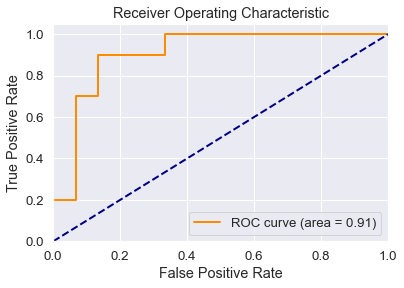

In [49]:
#2.0	[126, 8]	['relu', 'relu']	binary_crossentropy 	SGD	

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

layers_dict = {
            'inic' : {'uni': 126, 'activ': 'relu', 'input_s': (126,)},
            'l1' : {'uni': 126, 'activ': 'relu', 'dropout': 0.2},
            'l2' : {'uni': 8, 'activ': 'relu', 'dropout': 0.2},
            'end' : {'uni': 1, 'activ': 'sigmoid'},
            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'SGD', 'metrics' : ['accuracy']}
        }

model, results_df, y_pred_MLP, y_pred_prob_MLP, train_accuracy, test_accuracy = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T

# Accuracy
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_MLP)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_MLP, target_names=['0', '1']))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_MLP)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

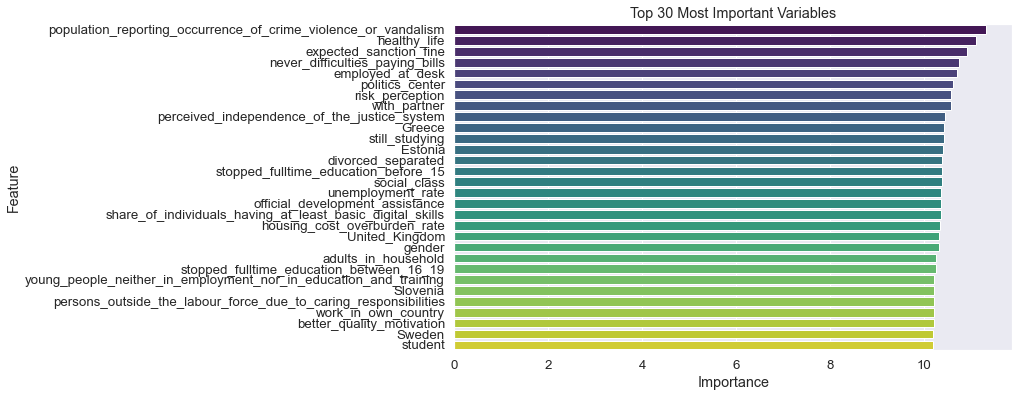

In [50]:
# Get the weights of the connections between the input layer and the first hidden layer
weights_layer1 = model.layers[1].get_weights()[0]  # Assuming 'l1' is the second layer in your model

# Calculate the absolute sum of weights for each input feature
feature_importance = np.abs(weights_layer1).sum(axis=1)

# Get the names of the input features from the DataFrame columns
input_feature_names = list(X.columns)

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': input_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select only the top 30 most important variables
top_30_importance_df = importance_df.head(30)

# Plot the importance of top 30 variables
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_30_importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()

# 3. Tab Net with CV

In [54]:
# Grid Search

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert pandas DataFrame to numpy array
X_train_array = X_train.values
X_test_array = X_test.values

# Define the parameter grid for the grid search
param_grid = {
    'gamma': [1.0, 1.5, 2.0],
    'lambda_sparse': [0.0, 1e-5, 1e-4],
    'mask_type': ['sparsemax', 'entmax'],
    'n_a': [16, 32, 64],
    'n_d': [8, 16, 32],
    'n_independent': [1, 2],
    'n_shared': [1, 2],
    'n_steps': [3, 5, 7],
    'optimizer_fn': [torch.optim.Adam, torch.optim.AdamW],
    'optimizer_params': [{'lr': 0.02}, {'lr': 0.01}]
}

# Initialize the TabNetClassifier
tabnet_model = TabNetClassifier()

# Define cross-validation strategy (Stratified K-Fold with 5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tabnet_model, param_grid=param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=2)

# Perform grid search on training set
grid_search.fit(X_train_array, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))



C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

In [68]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Ensure reproducibility
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert pandas DataFrame to numpy array
X_train_array = X_train.values
X_test_array = X_test.values

# Initialize the TabNetClassifier with the best parameters
tabnet_model = TabNetClassifier(
    gamma=2.0,
    lambda_sparse=0.0,
    mask_type='sparsemax',
    n_a=32,
    n_d=16,
    n_independent=2,
    n_shared=1,
    n_steps=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': 0.02}
)


# Define cross-validation strategy (Stratified K-Fold with 5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Fit the model to the entire training data
tabnet_model.fit(X_train_array, y_train)

# Perform cross-validation on training set
cv_scores = cross_val_score(tabnet_model, X_train_array, y_train, cv=skf, scoring='accuracy')
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(cv_scores.mean()))



C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.devi

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

epoch 31 | loss: 0.0     |  0:00:00s
epoch 32 | loss: 0.0     |  0:00:00s
epoch 33 | loss: 0.0     |  0:00:00s
epoch 34 | loss: 0.0     |  0:00:00s
epoch 35 | loss: 0.0     |  0:00:00s
epoch 36 | loss: 0.0     |  0:00:00s
epoch 37 | loss: 0.0     |  0:00:00s
epoch 38 | loss: 0.0     |  0:00:00s
epoch 39 | loss: 0.0     |  0:00:00s
epoch 40 | loss: 0.0     |  0:00:00s
epoch 41 | loss: 0.0     |  0:00:00s
epoch 42 | loss: 0.0     |  0:00:00s
epoch 43 | loss: 0.0     |  0:00:00s
epoch 44 | loss: 0.0     |  0:00:00s
epoch 45 | loss: 0.0     |  0:00:00s
epoch 46 | loss: 0.0     |  0:00:00s
epoch 47 | loss: 0.0     |  0:00:00s
epoch 48 | loss: 0.0     |  0:00:00s
epoch 49 | loss: 0.0     |  0:00:00s
epoch 50 | loss: 0.0     |  0:00:00s
epoch 51 | loss: 0.0     |  0:00:00s
epoch 52 | loss: 0.0     |  0:00:00s
epoch 53 | loss: 0.0     |  0:00:00s
epoch 54 | loss: 0.0     |  0:00:00s
epoch 55 | loss: 0.0     |  0:00:00s
epoch 56 | loss: 0.0     |  0:00:00s
epoch 57 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.devi

epoch 56 | loss: 0.0     |  0:00:00s
epoch 57 | loss: 0.0     |  0:00:00s
epoch 58 | loss: 0.0     |  0:00:00s
epoch 59 | loss: 0.0     |  0:00:00s
epoch 60 | loss: 0.0     |  0:00:00s
epoch 61 | loss: 0.0     |  0:00:00s
epoch 62 | loss: 0.0     |  0:00:00s
epoch 63 | loss: 0.0     |  0:00:00s
epoch 64 | loss: 0.0     |  0:00:00s
epoch 65 | loss: 0.0     |  0:00:00s
epoch 66 | loss: 0.0     |  0:00:00s
epoch 67 | loss: 0.0     |  0:00:00s
epoch 68 | loss: 0.0     |  0:00:00s
epoch 69 | loss: 0.0     |  0:00:00s
epoch 70 | loss: 0.0     |  0:00:00s
epoch 71 | loss: 0.0     |  0:00:00s
epoch 72 | loss: 0.0     |  0:00:00s
epoch 73 | loss: 0.0     |  0:00:00s
epoch 74 | loss: 0.0     |  0:00:00s
epoch 75 | loss: 0.0     |  0:00:00s
epoch 76 | loss: 0.0     |  0:00:00s
epoch 77 | loss: 0.0     |  0:00:00s
epoch 78 | loss: 0.0     |  0:00:00s
epoch 79 | loss: 0.0     |  0:00:00s
epoch 80 | loss: 0.0     |  0:00:00s
epoch 81 | loss: 0.0     |  0:00:00s
epoch 82 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Training Accuracy: 0.6804123711340206
Testing Accuracy: 0.52

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        15
           1       0.45      1.00      0.62        10

    accuracy                           0.52        25
   macro avg       0.73      0.60      0.48        25
weighted avg       0.78      0.52      0.45        25



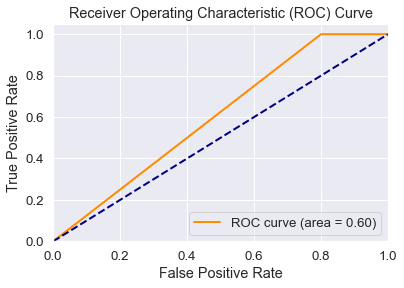

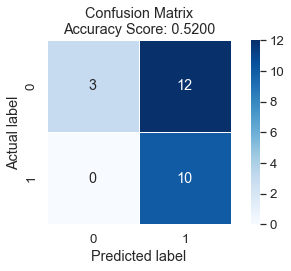

In [69]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Predict on training and testing data
y_train_pred = tabnet_model.predict(X_train_array)
y_test_pred_TABNET = tabnet_model.predict(X_test_array)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred_TABNET)

# Print train and test accuracy
print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)

# Generate classification report
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_test_pred_TABNET))

# Plot ROC curve
# Predict probabilities for the test set
y_prob_TABNET = tabnet_model.predict_proba(X_test_array)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_prob_TABNET)  
roc_auc_TABNET = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_TABNET)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot heatmap of the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_TABNET)
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix\nAccuracy Score: {test_acc:.4f}')

# Adjust layout
plt.tight_layout()
plt.show()

Top 30 Feature Importances:
                                               Feature  Importance
71                                        company_size    0.012423
110                              gender_employment_gap    0.012058
111  persons_outside_the_labour_force_due_to_caring...    0.008315
66                           better_quality_motivation    0.007885
38                                              farmer    0.007879
64                                low_price_motivation    0.007877
29                                     other_countries    0.007874
0                                                  age    0.007863
86                          without_fulltime_education    0.007863
83            stopped_fulltime_education_between_16_19    0.007863
84                 stopped_fulltime_education_after_20    0.007863
85                                      still_studying    0.007863
89                               children_in_household    0.007863
87                                

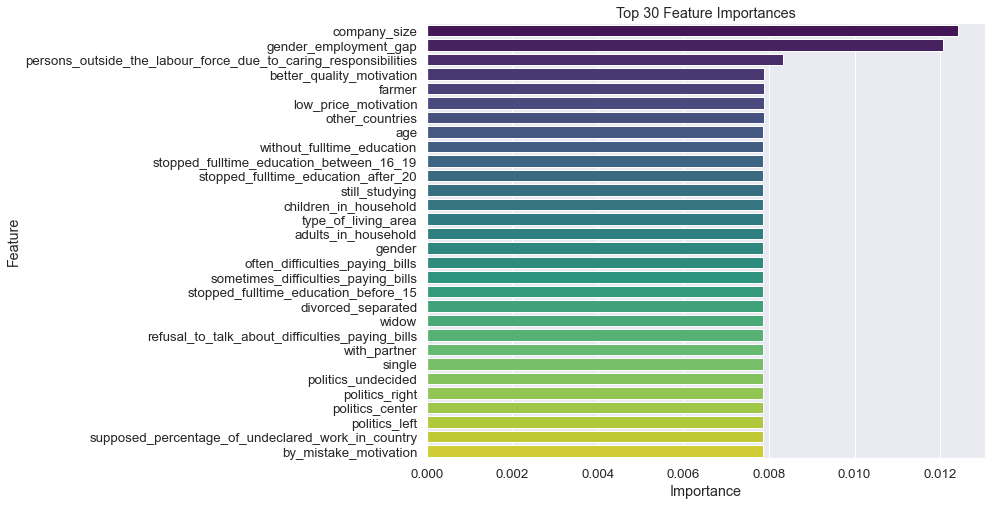

In [64]:
# Calculate feature importance
feature_importances = tabnet_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 30 most important features
top_30_features = feature_importance_df.head(30)

# Print top 30 feature importance
print("Top 30 Feature Importances:")
print(top_30_features)

# Plot top 30 feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 4. Convolutional Neural Networks

In [84]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#SET SEED
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of X_train:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dimensions of X_train: (97, 126)
Dimensions of X_test: (25, 126)
Dimensions of y_train: (97,)
Dimensions of y_test: (25,)


In [85]:

#Reshape the data into 2D grid-like structure based on the data's dimensions
# Here, we reshape it into a 14x9 grid
X_train_reshaped = X_train_scaled.reshape(-1, 14, 9, 1)
X_test_reshaped = X_test_scaled.reshape(-1, 14, 9, 1)
print("Dimensions of X_train_reshaped:", X_train_reshaped.shape)
print("Dimensions of X_test_reshaped:", X_test_reshaped.shape)


Dimensions of X_train_reshaped: (97, 14, 9, 1)
Dimensions of X_test_reshaped: (25, 14, 9, 1)


##  Functions to automatize experimenting-----------------------------------------

In [77]:
def add_layers(layers_dict):
    
    # SET SEEDS
    np.random.seed(140)
    tf.random.set_seed(134)
    tf.keras.utils.set_random_seed(44)
    torch.manual_seed(140)
    
    # Initialization
    model = Sequential()

    # Add input layer
    model.add(Input(shape=layers_dict['inic']['shape']))  

    # Add convolutional layers and pooling layers
    for i in range(1, len(layers_dict) - 2):  # Iterate over keys except 'inic' and 'end'
        conv_layer_info = layers_dict.get(f'conv{i}', None)
        pool_layer_info = layers_dict.get(f'pool{i}', None)
        
        if conv_layer_info:
            model.add(Conv2D(filters=conv_layer_info['filters'],
                             kernel_size=conv_layer_info['kernel_size'],
                             activation=conv_layer_info['activation'],
                             padding='same'))  # Use 'same' padding here
        if pool_layer_info:
            model.add(MaxPooling2D(pool_size=pool_layer_info['pool_size']))

    # Add flatten layer
    model.add(Flatten())

    # Add dense layers
    for i in range(1, len(layers_dict) - 2):
        dense_layer_info = layers_dict.get(f'dense{i}', None)
        if dense_layer_info:
            model.add(Dense(units=dense_layer_info['units'], activation=dense_layer_info['activation']))
            if 'dropout' in dense_layer_info:
                model.add(Dropout(rate=dense_layer_info['dropout']))

    # Add exit layer
    model.add(Dense(units=layers_dict['end']['units'], activation=layers_dict['end']['activation']))

    # Compile model
    model.compile(loss=layers_dict['compile']['loss'],
                  optimizer=layers_dict['compile']['optimizer'],
                  metrics=layers_dict['compile']['metrics'])
    
    return model

#--------------------------------------------------------------------------------------------------------
# Helper functions to count layers
def count_conv_layers(model):
    return sum(1 for layer in model.layers if isinstance(layer, Conv2D))

def count_pooling_layers(model):
    return sum(1 for layer in model.layers if isinstance(layer, MaxPooling2D))

def count_flatten_layers(model):
    return sum(1 for layer in model.layers if isinstance(layer, Flatten))

def count_dense_layers(model):
    # Exclude the output layer by iterating through all layers except the last one
    return sum(1 for layer in model.layers[:-1] if isinstance(layer, Dense))

#--------------------------------------------------------------------------------------------------------
def train_conv_model(model, X_train, X_test, y_train, y_test, **kwargs):
    epochs = kwargs.get('epochs', 5)
    batch_size = kwargs.get('batch_size', 1)
    verbose = kwargs.get('verbose', 1)
    
    # SET SEEDS
    np.random.seed(140)
    tf.random.set_seed(134)
    tf.keras.utils.set_random_seed(44)
    torch.manual_seed(140)

    # Training
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Predictions and evaluation on the test set
    y_pred_prob = model.predict(X_test)  
    y_pred = (y_pred_prob > 0.5)
    test_score = model.evaluate(X_test, y_test, verbose=1)
    train_score = model.evaluate(X_train, y_train, verbose=1)
    train_accuracy = train_score[1]
    test_accuracy = test_score[1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    # Put results in dataframe
    results = pd.Series({'Convolutional': count_conv_layers(model),
                         'Pooling': count_pooling_layers(model),
                         'Flatten': count_flatten_layers(model),
                         'Dense': count_dense_layers(model),
                         'Epochs': epochs,
                         'Batch_Size': batch_size,
                         'Train_accuracy':train_accuracy,
                         'Test_Accuracy': test_accuracy,
                         'Precision': precision,
                         'Recall': recall,
                         'F1_Score': f1,
                         'Kappa_Score': kappa})

    return model, results, y_pred, y_pred_prob, train_accuracy, test_accuracy

#----------------------------------------------------------------------------------------------------------------
def get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1):
  
    hidden = []
    f_activ = []
    for key in list(layers_dict.keys())[1:-2]:
        layer = layers_dict[key]
        if layer['type'] == 'conv2d' or layer['type'] == 'dense':
            if 'filters' in layer:
                hidden.append(layer['filters'])
            elif 'units' in layer:
                hidden.append(layer['units'])
            if 'activation' in layer:
                f_activ.append(layer['activation'])
                
    # SET SEEDS
    np.random.seed(140)
    tf.random.set_seed(134)
    tf.keras.utils.set_random_seed(44)
    torch.manual_seed(140)          

    model = add_layers(layers_dict)
    model, results_df, y_pred, y_pred_prob, train_accuracy, test_accuracy = train_conv_model(model, X_train, X_test, y_train, y_test, epochs=epochs, batch_size=batch_size, verbose=verbose)

    results_df['Hidden_units'] = str(hidden)
    results_df['F_activ'] = str(f_activ)
    results_df['Loss'] = layers_dict['compile']['loss']
    results_df['Optimizer'] = layers_dict['compile']['optimizer']
    
    results_df = results_df[['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Train_accuracy', 'Test_Accuracy',
                             'Precision', 'Recall', 'F1_Score', 'Kappa_Score']]

    return model, results_df, y_pred, y_pred_prob, train_accuracy, test_accuracy

In [102]:
#Form dataset to store models
df_all_results_CONV = pd.DataFrame(columns=['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Train_accuracy', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])
              

## FIND BEST CONVOLUTIONAL MODELS

In [103]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

file = 'dep_self_empl_CNN_relu.csv'


# List of common optimizers
optimizers = [
    'SGD',     # Stochastic Gradient Descent
    'Adam',    # Adam
    'Adamax'  # Adamax
]


    
# Loop through the list of optimizers and compile the model with each one
start_time = time.time()
for optimizer in optimizers:
    
    #RELU, 1 filtru, 1 strat-----------------------------------------------------------------------------------------------
   
    n = 0
    for f1 in [128, 64, 32, 16]:
        for d1 in [252, 126, 64, 32]:
                n = n + 1
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu', 'dropout': 0.5},                          # Dense layer 1
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 1filter, 1layer, " +  str(n) + "/16")
                model, results_df, predictions_CNN, predictions_proba_CNN, train_accuracyCNN, test_accuracyCNN = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    df_all_results_CONV.to_csv(file, index=False)



    # RELU, 2 filtre, 1 strat-------------------------------------------------------------------------------------------------
    n = 0
    for f1 in [128, 64, 32]:
        for f2 in [64, 32, 16]:
            for d1 in [252, 126, 64, 32]:
                n = n + 1
                
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'conv2': {'type': 'conv2d', 'filters': f2, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool2': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu', 'dropout': 0.5},                          # Dense layer 1
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 2filters, 1layer, " +  str(n) + "/36")
                model, results_df, predictions_CNN, predictions_proba_CNN, train_accuracyCNN, test_accuracyCNN = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    df_all_results_CONV.to_csv(file, index=False)


     #RELU, 1 filtru, 2 straturi------------------------------------------------------------------------------------------------
    n = 0
    for f1 in [128, 64, 32, 16]:
        for d1 in [252, 126, 64, 32]:
            for d2 in [ 64, 32]:
                n = n + 1
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu', 'dropout': 0.5},                          # Dense layer 1
                            'dense2': {'type': 'dense', 'units': d2, 'activation': 'relu', 'dropout': 0.5},
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 1filter, 2layers, " +  str(n) + "/32")  
                model, results_df, predictions_CNN, predictions_proba_CNN, train_accuracyCNN, test_accuracyCNN = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    df_all_results_CONV.to_csv(file, index=False)

    
     #RELU, 2 filtre, 2 straturi------------------------------------------------------------------------------------------------
    n = 0
    for f1 in [128, 64, 32 ]:
        for f2 in [ 32, 16]:
            for d1 in [252, 126, 64]:
                for d2 in [ 64, 32]:
                    n = n + 1
                    layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu', 'dropout': 0.5},                          # Dense layer 1
                            'dense2': {'type': 'dense', 'units': d2, 'activation': 'relu', 'dropout': 0.5},
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                    }

                    print(optimizer +  ": 2filters, 2layers, " +  str(n) + "/36")
                    model, results_df, predictions_CNN, predictions_proba_CNN, train_accuracyCNN, test_accuracyCNN = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                    #model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                    results_df = pd.DataFrame(results_df).T
                    df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                    print()
                    
    df_all_results_CONV.to_csv(file, index=False)

end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")

SGD: 1filter, 1layer, 1/16
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5610 - loss: 0.7180 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7494 - loss: 0.5626
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8908 - loss: 0.3401
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8921 - loss: 0.3063
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9175 - loss: 0.2234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8000 - loss: 0.4522
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0845 

SGD: 1filter, 1layer, 2/16
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5735 - loss: 0.7250
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7392 - loss: 0.5542
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8439 - loss: 0.4634
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8527 - loss: 0.3936
Epoch 5/5
97/9

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5010 - loss: 0.7276
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7384 - loss: 0.5555
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8610 - loss: 0.4238
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8746 - loss: 0.3054
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9118 - loss: 0.2364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8000 - loss: 0.4187
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9844 - loss: 0.1085 

SGD: 1filter, 1layer, 11/16
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4744 - loss: 0.7330
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7666 - loss: 0.5082 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7852 - loss: 0.4508
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8843 - loss: 0.3805
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6249 - loss: 0.7006
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6458 - loss: 0.6666
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7384 - loss: 0.5833
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7446 - loss: 0.5283
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7628 - loss: 0.4930
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6800 - loss: 0.5793
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9253 - loss: 0.3208 

SGD: 2filters, 1layer, 4/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4965 - loss: 0.7352 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5830 - loss: 0.6416
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7037 - loss: 0.5795
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7960 - loss: 0.4761
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5200 - loss: 0.7134 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6652 - loss: 0.6356
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7320 - loss: 0.5679
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8091 - loss: 0.4755
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7759 - loss: 0.5010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6800 - loss: 0.6370
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9274 - loss: 0.3060 

SGD: 2filters, 1layer, 13/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6035 - loss: 0.7087
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6515 - loss: 0.6332
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6929 - loss: 0.5896
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8529 - loss: 0.4710
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5789 - loss: 0.7029
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5899 - loss: 0.6922
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7446 - loss: 0.6302
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7726 - loss: 0.5612
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.5406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6800 - loss: 0.5590
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9118 - loss: 0.3630 

SGD: 2filters, 1layer, 22/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4956 - loss: 0.7065 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5388 - loss: 0.6632
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7227 - loss: 0.5842
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.5328
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5755 - loss: 0.6932 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5487 - loss: 0.6564
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7372 - loss: 0.5530
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8141 - loss: 0.4590
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8252 - loss: 0.4183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6800 - loss: 0.5503
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9398 - loss: 0.2631 

SGD: 2filters, 1layer, 31/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4648 - loss: 0.7265
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6440 - loss: 0.6724
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7170 - loss: 0.5812
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8238 - loss: 0.4911
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6347 - loss: 0.7053
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6675 - loss: 0.6528 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6157 - loss: 0.6183
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8008 - loss: 0.4573
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7993 - loss: 0.4291
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8000 - loss: 0.4646
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9741 - loss: 0.2075 

SGD: 1filter, 2layers, 4/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5312 - loss: 0.7047
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5753 - loss: 0.6923
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6683 - loss: 0.6312
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7355 - loss: 0.5456
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5152 - loss: 0.7348
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4646 - loss: 0.7190
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6056 - loss: 0.6756
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6313 - loss: 0.6280
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7066 - loss: 0.5239
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7600 - loss: 0.4699
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9098 - loss: 0.3668 

SGD: 1filter, 2layers, 13/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5078 - loss: 0.7177
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5665 - loss: 0.6862
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 0.6198
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6999 - loss: 0.5667
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4878 - loss: 0.7476   
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5855 - loss: 0.6759
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5655 - loss: 0.6911 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7450 - loss: 0.5539
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7016 - loss: 0.5587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8000 - loss: 0.4544
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9346 - loss: 0.3222 

SGD: 1filter, 2layers, 22/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4879 - loss: 0.6814
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6666 - loss: 0.6350
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6101 - loss: 0.6459
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6430 - loss: 0.6396
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5393 - loss: 0.6986
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5786 - loss: 0.6937
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6425 - loss: 0.6648
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6415 - loss: 0.6408
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6313 - loss: 0.6385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7200 - loss: 0.5507
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9316 - loss: 0.4729 

SGD: 1filter, 2layers, 31/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4502 - loss: 0.7841   
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3807 - loss: 0.7627 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6519 - loss: 0.6524
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 0.6412
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4723 - loss: 0.7096
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5768 - loss: 0.6727
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7260 - loss: 0.5992
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8501 - loss: 0.4472
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8473 - loss: 0.4704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7600 - loss: 0.3870
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9782 - loss: 0.1493 

SGD: 2filters, 2layers, 8/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4585 - loss: 0.7256
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5277 - loss: 0.7050
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6773 - loss: 0.5834
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7645 - loss: 0.5311
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5152 - loss: 0.7348
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4646 - loss: 0.7190
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6056 - loss: 0.6756
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6313 - loss: 0.6280
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7066 - loss: 0.5239
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7600 - loss: 0.4699
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9098 - loss: 0.3668 

SGD: 2filters, 2layers, 17/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5078 - loss: 0.7177
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5665 - loss: 0.6862
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 0.6198
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6999 - loss: 0.5667
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4964 - loss: 0.6967
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7140 - loss: 0.5992
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5891 - loss: 0.6684
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8027 - loss: 0.5050
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8272 - loss: 0.4127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8000 - loss: 0.4129
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9720 - loss: 0.1761 

SGD: 2filters, 2layers, 26/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5464 - loss: 0.7406
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6164 - loss: 0.6577
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7313 - loss: 0.5831
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6764 - loss: 0.5671
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6360 - loss: 0.7036
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6030 - loss: 0.7031 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6286 - loss: 0.6366
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7322 - loss: 0.5654
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7840 - loss: 0.4663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7600 - loss: 0.5114
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9306 - loss: 0.2904 

SGD: 2filters, 2layers, 35/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4878 - loss: 0.7476   
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5855 - loss: 0.6759
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5655 - loss: 0.6911 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7450 - loss: 0.5539
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4854 - loss: 0.8449  
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6613 - loss: 0.6241
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6846 - loss: 0.5327
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.5024
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8830 - loss: 0.2782
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7200 - loss: 0.4213
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9782 - loss: 0.1419 

Adam: 1filter, 1layer, 8/16
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3478 - loss: 0.8059    
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6479 - loss: 0.6136
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8275 - loss: 0.5358
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7033 - loss: 0.5418
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5257 - loss: 0.7740
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6308 - loss: 0.6130 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7257 - loss: 0.5938
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7137 - loss: 0.5010
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8472 - loss: 0.3647
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6800 - loss: 0.4684
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9626 - loss: 0.2152 

Adam: 2filters, 1layer, 1/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5261 - loss: 0.7480
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6162 - loss: 0.6219
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8197 - loss: 0.4244
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9114 - loss: 0.2624
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5778 - loss: 0.7201  
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6033 - loss: 0.6419
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7419 - loss: 0.5012
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8935 - loss: 0.3619
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9235 - loss: 0.3042
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6400 - loss: 0.6629
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0792 

Adam: 2filters, 1layer, 10/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5844 - loss: 0.7185
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7546 - loss: 0.6101
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7944 - loss: 0.4804
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - loss: 0.3786
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6026 - loss: 0.7274
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6447 - loss: 0.6501
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8396 - loss: 0.4992
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8681 - loss: 0.3807
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - loss: 0.2419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7200 - loss: 0.6206
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9585 - loss: 0.1472 

Adam: 2filters, 1layer, 19/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5103 - loss: 0.7302
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6145 - loss: 0.6316
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7686 - loss: 0.5161
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8345 - loss: 0.4342
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5266 - loss: 0.7425
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6554 - loss: 0.6274
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7208 - loss: 0.5327
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8366 - loss: 0.4555
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8266 - loss: 0.4080
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7200 - loss: 0.4849
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9720 - loss: 0.1821 

Adam: 2filters, 1layer, 28/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4804 - loss: 0.7760
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7334 - loss: 0.6182
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7080 - loss: 0.5885
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.4672
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5951 - loss: 0.7270
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7424 - loss: 0.6111
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7485 - loss: 0.5188
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8246 - loss: 0.4527
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7377 - loss: 0.4613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7600 - loss: 0.6399
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9440 - loss: 0.2798 

Adam: 1filter, 2layers, 1/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6676 - loss: 1.0085
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4940 - loss: 0.8565
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6946 - loss: 0.5538
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8181 - loss: 0.3968
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step -

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5441 - loss: 0.9765
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5344 - loss: 0.7854
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6206 - loss: 0.6082
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8425 - loss: 0.3782
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8794 - loss: 0.3656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7200 - loss: 0.4841
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9782 - loss: 0.1356 

Adam: 1filter, 2layers, 10/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4677 - loss: 0.9281
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5354 - loss: 0.7435
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5761 - loss: 0.6490
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7527 - loss: 0.4910
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5682 - loss: 0.8994
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4931 - loss: 0.8580
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6533 - loss: 0.5982
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6610 - loss: 0.5740
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7754 - loss: 0.4898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8000 - loss: 0.4535
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.2352 

Adam: 1filter, 2layers, 19/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4250 - loss: 0.9212
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5797 - loss: 0.7631 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5633 - loss: 0.6947
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8028 - loss: 0.4999
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5526 - loss: 0.8188
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5468 - loss: 0.8754
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5800 - loss: 0.6597
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8010 - loss: 0.4788
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7242 - loss: 0.5161
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7600 - loss: 0.4817
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9679 - loss: 0.2915 

Adam: 1filter, 2layers, 28/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4134 - loss: 0.8397 
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4868 - loss: 0.7584
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5359 - loss: 0.6761
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6669 - loss: 0.6466
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5137 - loss: 0.8770
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5378 - loss: 0.7904
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6646 - loss: 0.6164
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7851 - loss: 0.4906
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8322 - loss: 0.3910
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7600 - loss: 0.4693
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9689 - loss: 0.1719 

Adam: 2filters, 2layers, 5/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5705 - loss: 0.7964
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5107 - loss: 0.7272
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7197 - loss: 0.5936
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8080 - loss: 0.5607
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5441 - loss: 0.9765
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5344 - loss: 0.7854
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6206 - loss: 0.6082
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8425 - loss: 0.3782
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8794 - loss: 0.3656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7200 - loss: 0.4841
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9782 - loss: 0.1356 

Adam: 2filters, 2layers, 14/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4677 - loss: 0.9281
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5354 - loss: 0.7435
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5761 - loss: 0.6490
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7527 - loss: 0.4910
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4445 - loss: 0.9199
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3964 - loss: 0.8833
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5901 - loss: 0.6718
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7397 - loss: 0.6107
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7626 - loss: 0.5323
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7600 - loss: 0.4991
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9315 - loss: 0.3111 

Adam: 2filters, 2layers, 23/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5960 - loss: 0.8008
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4864 - loss: 0.8642 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6871 - loss: 0.6416
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7050 - loss: 0.5652
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5115 - loss: 0.8874
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5515 - loss: 0.7571
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7040 - loss: 0.6477
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7976 - loss: 0.3989
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7637 - loss: 0.4437
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6800 - loss: 0.4853
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9720 - loss: 0.1514 

Adam: 2filters, 2layers, 32/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5682 - loss: 0.8994
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4931 - loss: 0.8580
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6533 - loss: 0.5982
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6610 - loss: 0.5740
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5153 - loss: 0.8189
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7279 - loss: 0.6039
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8066 - loss: 0.5265
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7807 - loss: 0.5231
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8693 - loss: 0.4245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8000 - loss: 0.4948
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9346 - loss: 0.3736 

Adamax: 1filter, 1layer, 5/16
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6297 - loss: 0.7540
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7236 - loss: 0.5850
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7395 - loss: 0.5068
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7706 - loss: 0.4112
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5514 - loss: 0.7691
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6432 - loss: 0.6026
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7533 - loss: 0.5331
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8516 - loss: 0.4393
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7959 - loss: 0.4178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7600 - loss: 0.4763
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9689 - loss: 0.2987 

Adamax: 1filter, 1layer, 14/16
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4688 - loss: 0.8355
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6330 - loss: 0.6310
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6808 - loss: 0.5763
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8387 - loss: 0.4688
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5181 - loss: 0.7210  
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6135 - loss: 0.6638
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7632 - loss: 0.6169
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8461 - loss: 0.5270
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8130 - loss: 0.5116
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7600 - loss: 0.5701
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9025 - loss: 0.4263 

Adamax: 2filters, 1layer, 7/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4934 - loss: 0.7072  
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6012 - loss: 0.6615
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7150 - loss: 0.5579
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7884 - loss: 0.5359
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5714 - loss: 0.7281
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6063 - loss: 0.6494
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6914 - loss: 0.5801
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7146 - loss: 0.5632
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7915 - loss: 0.5375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7600 - loss: 0.5450
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9212 - loss: 0.4271 

Adamax: 2filters, 1layer, 16/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4678 - loss: 0.7741  
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6636 - loss: 0.6301
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7266 - loss: 0.5934
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7770 - loss: 0.5494
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5548 - loss: 0.7266  
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7518 - loss: 0.6492
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7391 - loss: 0.6177
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7932 - loss: 0.5676
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6569 - loss: 0.5796
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7200 - loss: 0.5895
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8817 - loss: 0.5118 

Adamax: 2filters, 1layer, 25/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5975 - loss: 0.7587
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6094 - loss: 0.6479
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7595 - loss: 0.5581
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8325 - loss: 0.4952
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4511 - loss: 0.7247  
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6840
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8132 - loss: 0.6103
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7523 - loss: 0.5669
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7469 - loss: 0.5932
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7600 - loss: 0.5860
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8807 - loss: 0.4882 

Adamax: 2filters, 1layer, 34/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5616 - loss: 0.6989
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5869 - loss: 0.6578
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7002 - loss: 0.6037
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7049 - loss: 0.5916
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5539 - loss: 0.7947
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5142 - loss: 0.7491
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5415 - loss: 0.6930
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6363 - loss: 0.6330
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6623 - loss: 0.5914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7600 - loss: 0.6336
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8289 - loss: 0.5609 

Adamax: 1filter, 2layers, 7/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5670 - loss: 0.7816
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5863 - loss: 0.7271 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6284 - loss: 0.6414
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5642 - loss: 0.6499
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5942 - loss: 0.7108
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5327 - loss: 0.6923 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6778 - loss: 0.6278
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5170 - loss: 0.7244 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6047 - loss: 0.6673
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7600 - loss: 0.6411
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8817 - loss: 0.6221 

Adamax: 1filter, 2layers, 16/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5372 - loss: 0.7903
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5465 - loss: 0.6772
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5417 - loss: 0.6756
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5789 - loss: 0.6214
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5749 - loss: 0.7810
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5532 - loss: 0.6865
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5681 - loss: 0.6653
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6357 - loss: 0.6743
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7227 - loss: 0.5893
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6000 - loss: 0.6623
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8039 - loss: 0.6048 

Adamax: 1filter, 2layers, 25/32
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5554 - loss: 0.8505
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5567 - loss: 0.7313
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6108 - loss: 0.6630 
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6168 - loss: 0.6438 
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6309 - loss: 0.8222
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5606 - loss: 0.7439
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5800 - loss: 0.6420
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7173 - loss: 0.5108
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7628 - loss: 0.5926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8000 - loss: 0.4957
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8879 - loss: 0.3900 

Adamax: 2filters, 2layers, 2/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5193 - loss: 0.7758
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4228 - loss: 0.8411
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6297 - loss: 0.6694
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6644 - loss: 0.5825
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/ste

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5218 - loss: 0.8065
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4778 - loss: 0.7603
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6368 - loss: 0.6025
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6223 - loss: 0.6439
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7171 - loss: 0.5753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8000 - loss: 0.5465
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8931 - loss: 0.4810 

Adamax: 2filters, 2layers, 11/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5689 - loss: 0.7338
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4967 - loss: 0.7315
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6500 - loss: 0.6574
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6334 - loss: 0.5989
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5469 - loss: 0.8168
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5543 - loss: 0.7098
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5588 - loss: 0.6734
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7028 - loss: 0.5613
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6430 - loss: 0.6471
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8000 - loss: 0.5211
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8870 - loss: 0.4498 

Adamax: 2filters, 2layers, 20/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4752 - loss: 0.8364
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5087 - loss: 0.7400
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6455 - loss: 0.6436
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5889 - loss: 0.6478
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5729 - loss: 0.7474
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5646 - loss: 0.6741
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5038 - loss: 0.6487
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6469 - loss: 0.6432
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6287 - loss: 0.5770
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6800 - loss: 0.5667
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8652 - loss: 0.5040 

Adamax: 2filters, 2layers, 29/36
Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4768 - loss: 0.7585    
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6637 - loss: 0.6242
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6333 - loss: 0.6864
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6727 - loss: 0.5905
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

In [104]:
x = pd.read_csv('dep_self_empl_CNN_relu.csv')
x.sort_values(by='Test_Accuracy', ascending=False)

,Convolutional,Pooling,Flatten,Dense,Hidden_units,F_activ,Loss,Optimizer,Epochs,Batch_Size,Train_accuracy,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
5,1.0,1.0,1.0,1.0,"[64, 126]","['relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.979381,0.88,0.818182,0.9,0.857143,0.754098
314,1.0,1.0,1.0,2.0,"[32, 32, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.804124,0.88,0.888889,0.8,0.842105,0.745763
133,1.0,1.0,1.0,1.0,"[16, 126]","['relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.989691,0.84,0.750000,0.9,0.818182,0.677419
173,1.0,1.0,1.0,2.0,"[128, 252, 32]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.000000,0.84,0.750000,0.9,0.818182,0.677419
125,1.0,1.0,1.0,1.0,"[64, 126]","['relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,1.000000,0.84,0.750000,0.9,0.818182,0.677419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,1.0,1.0,1.0,2.0,"[128, 64, 64]","['relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.927835,0.60,0.500000,0.6,0.545455,0.193548
56,1.0,1.0,1.0,2.0,"[128, 64, 64]","['relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.927835,0.60,0.500000,0.6,0.545455,0.193548
202,1.0,1.0,1.0,2.0,"[16, 32, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.824742,0.56,0.470588,0.8,0.592593,0.179104
323,1.0,1.0,1.0,2.0,"[16, 32, 32]","['relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.659794,0.48,0.434783,1.0,0.606061,0.109589


## Experiment changing Relu to Tanh

In [117]:
#Form dataset to store results of models
df_all_results_CONV_tanh = pd.DataFrame(columns=['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Train_accuracy', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])


In [122]:
#1.0	1.0	1.0	1.0	[64, 126]	['relu', 'relu']	binary_crossentropy	SGD	

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)


layers_dict = {
                'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                'conv1': {'type': 'conv2d', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'tanh'},  # Convolutional layer 1
                'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                'flatten': {'type': 'flatten'},                                                           # Flatten layer
                'dense1': {'type': 'dense', 'units': 126, 'activation': 'relu', 'dropout': 0.5},                          # Dense layer 1
                'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                'compile': {'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'metrics': ['accuracy']}
                }


model, results_df,  y_pred, y_pred_prob, train_accuracy, test_accuracy = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_CONV_tanh = pd.concat([df_all_results_CONV_tanh, results_df], ignore_index=True)
print(train_accuracy, test_accuracy)


Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4643 - loss: 0.7504
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7054 - loss: 0.6135 
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8585 - loss: 0.4655
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8553 - loss: 0.3757
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9142 - loss: 0.2439
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8400 - loss: 0.4241
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9626 - loss: 0.1496 
0.969072163105011 0.8399999737739563


In [123]:
df_all_results_CONV_tanh.to_csv('dep_self_empl_CNN_tanh.csv', index=False)

In [124]:
y = pd.read_csv('dep_self_empl_CNN_tanh.csv')
y.sort_values(by='Test_Accuracy', ascending=False).head(10)

,Convolutional,Pooling,Flatten,Dense,Hidden_units,F_activ,Loss,Optimizer,Epochs,Batch_Size,Train_accuracy,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
1,1.0,1.0,1.0,1.0,"[64, 126]","['tanh', 'tanh']",binary_crossentropy,SGD,5.0,1.0,1.000000,0.84,0.750000,0.9,0.818182,0.677419
2,1.0,1.0,1.0,1.0,"[64, 126]","['tanh', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.969072,0.84,0.800000,0.8,0.800000,0.666667
0,1.0,1.0,1.0,1.0,"[64, 126]","['relu', 'tanh']",binary_crossentropy,SGD,5.0,1.0,1.000000,0.80,0.727273,0.8,0.761905,0.590164


## MODEL CNN FINAL 

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4630 - loss: 0.7534
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7687 - loss: 0.6042
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8725 - loss: 0.4412
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8891 - loss: 0.3411
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9239 - loss: 0.2131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8800 - loss: 0.3822
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9782 - loss: 0.1184 


Training Accuracy: 0.9794
Test Accuracy: 0.8800

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.82      0.90      0.86        10

    accuracy                           0.88        25
   macro avg       0.87      0.88      0.88        25
weighted avg       0.88      0.88      0.88        25



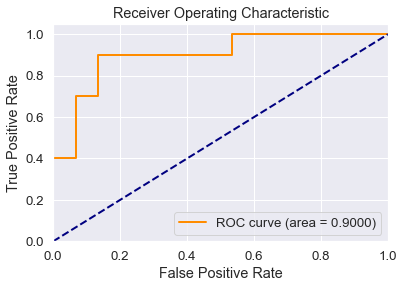

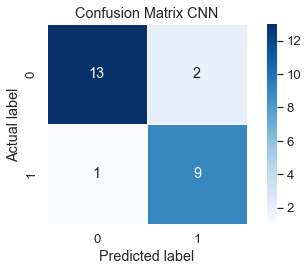

In [125]:

#------------------------------------------------------------------------------------------------------------------------------

##1.0	1.0	1.0	1.0	[64, 126]	['relu', 'relu']	binary_crossentropy	SGD	

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)


layers_dict = {
                'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                'conv1': {'type': 'conv2d', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                'flatten': {'type': 'flatten'},                                                           # Flatten layer
                'dense1': {'type': 'dense', 'units': 126, 'activation': 'relu', 'dropout': 0.5},          # Dense layer 1
                'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                'compile': {'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'metrics': ['accuracy']}
                }


model, results_df,  predictions_CNN,  predictions_proba_CNN, train_accuracyCNN, test_accuracyCNN = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_CONV_tanh = pd.concat([df_all_results_CONV_tanh, results_df], ignore_index=True)
print()


# accuracy
print(f"\nTraining Accuracy: {train_accuracyCNN:.4f}")
print(f"Test Accuracy: {test_accuracyCNN:.4f}")

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions_CNN))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, predictions_proba_CNN)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Plot heatmap of the confusion matrix
cm = confusion_matrix(y_test, predictions_CNN)
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix CNN')

# Adjust layout
plt.tight_layout()
plt.show()

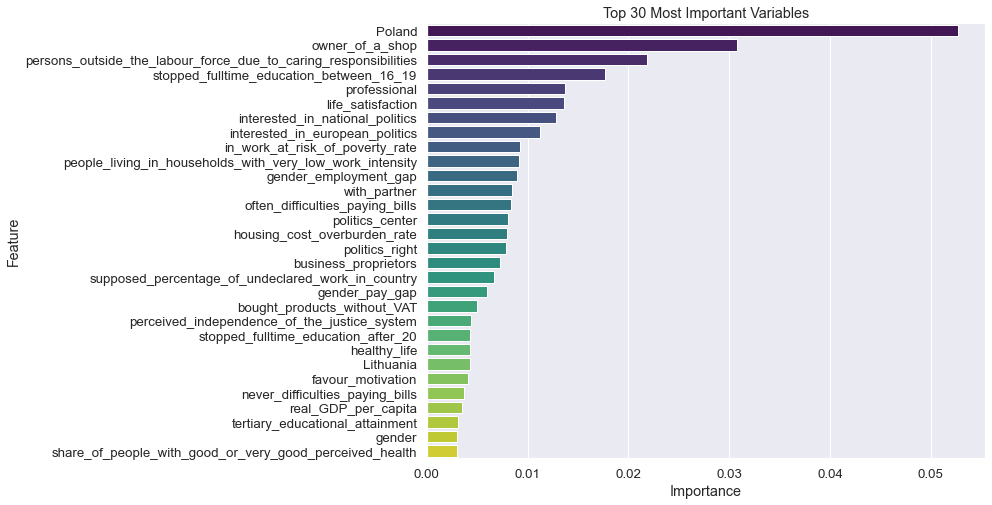

In [127]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Define and compile the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14, 9, 1)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(126, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=5, batch_size=1, shuffle=False, verbose=0)

# Function to compute integrated gradients
@tf.function
def integrated_gradients(input_data):
    baseline = tf.zeros_like(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        predictions = model(input_data)
    grads = tape.gradient(predictions, input_data)
    integrated_grads = (input_data - baseline) * grads
    return tf.reduce_mean(integrated_grads, axis=0)

# Compute integrated gradients for each sample in the test set
ig_list = []
for sample in X_test_reshaped:
    ig = integrated_gradients(tf.convert_to_tensor([sample]))
    ig_list.append(ig.numpy())

# Calculate the mean importance across the test set
feature_importance = np.mean(ig_list, axis=0)

# Flatten feature_importance if it's not already 1D
feature_importance = feature_importance.flatten()

# Assuming X_train_reshaped was reshaped from a DataFrame X, with columns corresponding to the original feature names
input_feature_names = [f"Feature_{i}" for i in range(X_train_reshaped.shape[1] * X_train_reshaped.shape[2])]
input_feature_names = list(X.columns)

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': input_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select only the top 30 most important variables
top_30_importance_df = importance_df.head(30)

# Plot the importance of top 30 variables
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()


# ROC GRAPHICS

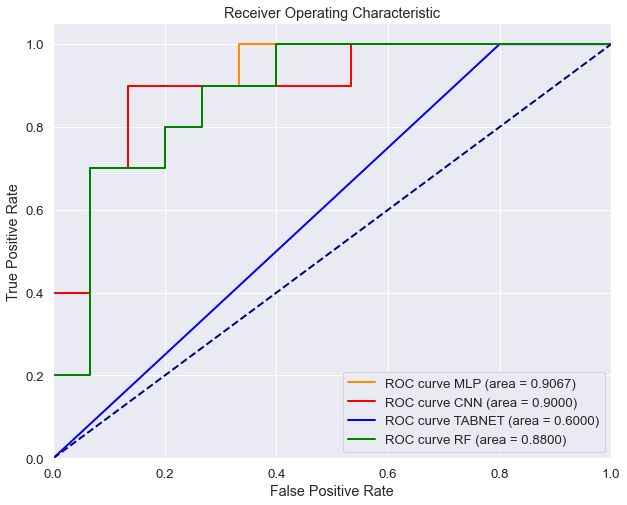

In [128]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))  # Adjust the size of the plot

# MLP
fpr1, tpr1, _ = roc_curve(y_test, y_pred_prob_MLP)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve MLP (area = {roc_auc1:.4f})')

# CNN
fpr4, tpr4, _ = roc_curve(y_test, predictions_proba_CNN)
roc_auc4 = auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, color='red', lw=2, label=f'ROC curve CNN (area = {roc_auc4:.4f})')

# TAB NET
fpr2, tpr2, _ = roc_curve(y_test, y_prob_TABNET)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, color='blue', lw=2, label=f'ROC curve TABNET (area = {roc_auc2:.4f})')

# RF
fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba_RF)
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, color='green', lw=2, label=f'ROC curve RF (area = {roc_auc3:.4f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')  # Move legend to lower right corner
plt.show()



## Heatmap Confusion Matrix

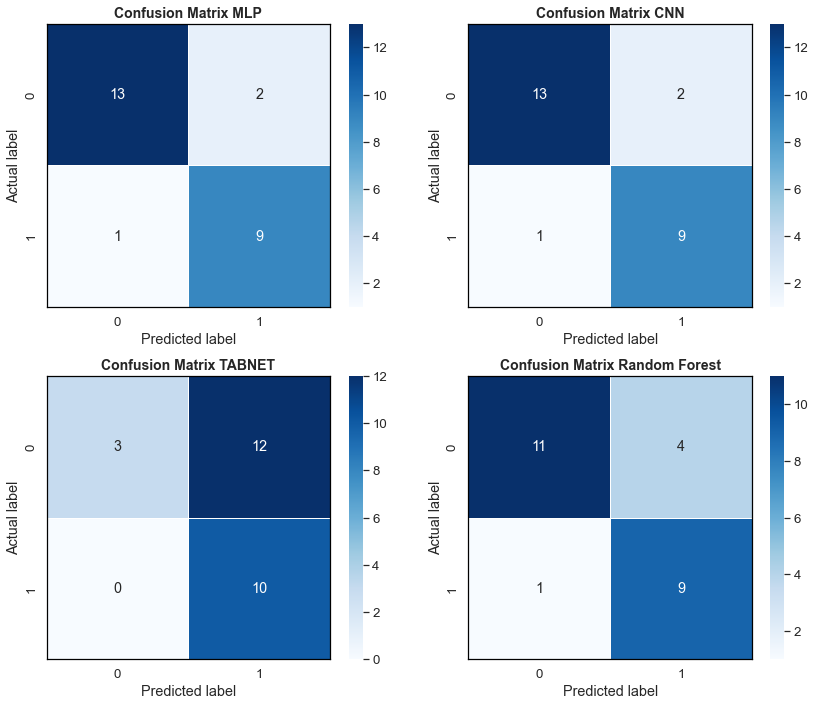

In [129]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Set common title properties
title_props = {'fontsize': 14, 'fontweight': 'bold'}

# Loop through each subplot and plot the confusion matrix
for i, ax in enumerate(axes.flat):
    if i == 0:
        cm = confusion_matrix(y_test, y_pred_MLP)
        title = 'Confusion Matrix MLP'
    elif i == 1:
        cm = confusion_matrix(y_test, predictions_CNN)
        title = 'Confusion Matrix CNN'
    elif i == 2:
        cm = confusion_matrix(y_test, y_test_pred_TABNET)
        title = 'Confusion Matrix TABNET'
    else:
        cm = confusion_matrix(y_test, y_pred_RF)
        title = 'Confusion Matrix Random Forest'
    
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', linewidths=1, square=True, cmap='Blues', ax=ax)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title, **title_props)
    
    # Draw borders around each heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')

# Adjust layout
plt.tight_layout()
plt.show()
